# 01 — Data Preprocessing

## Objectif
Ce notebook prépare les données (CV, Jobs, correspondances) pour construire le graphe biparti CV–Job et pour les étapes suivantes (analyse, communautés, link prediction, classification).

### Étapes réalisées
1. Chargement des données brutes (raw)
2. Inspection rapide et contrôles de qualité
3. Nettoyage du texte (CV et Job)
4. Normalisation des compétences (skills) (optionnel mais utile)
5. Création des tables propres (processed) :
   - `cv_clean.csv` (nœuds CV)
   - `job_clean.csv` (nœuds Job)
   - `edges.csv` (arêtes CV↔Job)
6. Statistiques descriptives de base
7. Sauvegarde des données prétraitées

In [1]:
import os
import re
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# (optionnel mais pratique)
from tqdm import tqdm
tqdm.pandas()

plt.rcParams["figure.figsize"] = (7, 4)

## 1) Chemins des fichiers

On suppose la structure suivante :
- `data/raw/` : données brutes (générées ou fournies)
- `data/processed/` : données prétraitées (sorties de ce notebook)

In [4]:
RAW_DIR = "data/raw"
PROC_DIR = "data/processed"

CV_RAW_PATH = os.path.join(RAW_DIR, "cv_raw.csv")
JOB_RAW_PATH = os.path.join(RAW_DIR, "job_raw.csv")
EDGES_RAW_PATH = os.path.join(RAW_DIR, "matches_raw.csv")

CV_PROC_PATH = os.path.join(PROC_DIR, "cv_clean.csv")
JOB_PROC_PATH = os.path.join(PROC_DIR, "job_clean.csv")
EDGES_PROC_PATH = os.path.join(PROC_DIR, "edges.csv")

os.makedirs(PROC_DIR, exist_ok=True)

print("CV_RAW_PATH:", CV_RAW_PATH)
print("JOB_RAW_PATH:", JOB_RAW_PATH)
print("EDGES_RAW_PATH:", EDGES_RAW_PATH)

CV_RAW_PATH: data/raw/cv_raw.csv
JOB_RAW_PATH: data/raw/job_raw.csv
EDGES_RAW_PATH: data/raw/matches_raw.csv


## 2) Chargement des données brutes
Nous chargeons :
- `cv_raw.csv` : profils (CV)
- `job_raw.csv` : offres (Jobs)
- `matches_raw.csv` : liens existants CV↔Job (match connu)

In [5]:
cv_df = pd.read_csv(CV_RAW_PATH)
job_df = pd.read_csv(JOB_RAW_PATH)
edges_df = pd.read_csv(EDGES_RAW_PATH)

print("Nombre de CV:", len(cv_df))
print("Nombre de Jobs:", len(job_df))
print("Nombre de matches:", len(edges_df))

cv_df.head(3)


Nombre de CV: 300
Nombre de Jobs: 90
Nombre de matches: 1200


,cv_id,text,skills,level,profile_type,domain
0,CV_0000,CV Profile: junior candidate in design. Experi...,"linux, javascript, scrum, git, python, budgeti...",junior,polyvalent,design
1,CV_0001,CV Profile: intermediate candidate in design. ...,"typography, design systems, adobe photoshop, u...",intermediate,specialized,design
2,CV_0002,CV Profile: junior candidate in management. Ex...,"agile, scrum, budgeting, communication, planni...",junior,specialized,management


In [6]:
job_df.head(3)

,job_id,text,skills,level_required,domain
0,JOB_0000,Job Offer: junior position in cybersecurity. W...,"linux, risk assessment, firewalls, penetration...",junior,cybersecurity
1,JOB_0001,Job Offer: intermediate position in cybersecur...,"siem, linux, penetration testing, risk assessm...",intermediate,cybersecurity
2,JOB_0002,Job Offer: intermediate position in cybersecur...,"penetration testing, incident response, risk a...",intermediate,cybersecurity


In [7]:
edges_df.head(3)

,cv_id,job_id,label
0,CV_0000,JOB_0070,1
1,CV_0000,JOB_0038,1
2,CV_0000,JOB_0018,1


## 3) Contrôles de qualité (sanity checks)

Vérifications :
- colonnes attendues
- IDs uniques (CV et Job)
- pas de valeurs manquantes critiques
- cohérence des arêtes : `cv_id` et `job_id` présents dans les tables nœuds

In [8]:
# Colonnes minimales attendues
assert "cv_id" in cv_df.columns and "text" in cv_df.columns
assert "job_id" in job_df.columns and "text" in job_df.columns
assert "cv_id" in edges_df.columns and "job_id" in edges_df.columns

# Unicité des IDs (attendue)
print("CV IDs uniques:", cv_df["cv_id"].nunique(), "/", len(cv_df))
print("Job IDs uniques:", job_df["job_id"].nunique(), "/", len(job_df))

# Valeurs manquantes dans texte
print("CV text missing:", cv_df["text"].isna().mean())
print("Job text missing:", job_df["text"].isna().mean())

# Cohérence edges: IDs existants ?
missing_cv = ~edges_df["cv_id"].isin(cv_df["cv_id"])
missing_job = ~edges_df["job_id"].isin(job_df["job_id"])
print("Edges avec cv_id manquant:", missing_cv.sum())
print("Edges avec job_id manquant:", missing_job.sum())

CV IDs uniques: 300 / 300
Job IDs uniques: 90 / 90
CV text missing: 0.0
Job text missing: 0.0
Edges avec cv_id manquant: 0
Edges avec job_id manquant: 0


## 4) Nettoyage du texte

On crée une version `clean_text` :
- minuscules
- suppression ponctuation
- suppression chiffres
- normalisation espaces

> Remarque : on garde le texte original dans `text` et on travaille avec `clean_text`.
  

In [9]:
def clean_text(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [10]:
cv_df["clean_text"] = cv_df["text"].progress_apply(clean_text)
job_df["clean_text"] = job_df["text"].progress_apply(clean_text)

cv_df[["cv_id", "text", "clean_text"]].head(2)

100%|██████████| 90/90 [00:00<00:00, 24898.58it/s]


,cv_id,text,clean_text
0,CV_0000,CV Profile: junior candidate in design. Experi...,cv profile junior candidate in design experien...
1,CV_0001,CV Profile: intermediate candidate in design. ...,cv profile intermediate candidate in design ex...


## 5) Normalisation des compétences (skills)

Si la colonne `skills` existe (séparée par virgules), on :
- met en minuscules
- strip espaces
- normalise certains alias (ex: ML → machine learning)
- crée `skills_norm` (liste Python) et `skills_norm_str` (string)

In [11]:
def normalize_skills(skill_string):
    if pd.isna(skill_string):
        return []
    skills = [s.strip().lower() for s in str(skill_string).split(",") if s.strip()]

    normalization = {
        "ml": "machine learning",
        "ai": "artificial intelligence",
        "dl": "deep learning",
        "bi": "business intelligence"
    }
    skills = [normalization.get(s, s) for s in skills]
    # unique en gardant l'ordre
    skills = list(dict.fromkeys(skills))
    return skills

if "skills" in cv_df.columns:
    cv_df["skills_norm"] = cv_df["skills"].apply(normalize_skills)
    cv_df["skills_norm_str"] = cv_df["skills_norm"].apply(lambda x: ", ".join(x))

if "skills" in job_df.columns:
    job_df["skills_norm"] = job_df["skills"].apply(normalize_skills)
    job_df["skills_norm_str"] = job_df["skills_norm"].apply(lambda x: ", ".join(x))

# Aperçu si dispo
cols = [c for c in ["cv_id", "skills", "skills_norm_str"] if c in cv_df.columns]
cv_df[cols].head(3)

,cv_id,skills,skills_norm_str
0,CV_0000,"linux, javascript, scrum, git, python, budgeti...","linux, javascript, scrum, git, python, budgeti..."
1,CV_0001,"typography, design systems, adobe photoshop, u...","typography, design systems, adobe photoshop, u..."
2,CV_0002,"agile, scrum, budgeting, communication, planni...","agile, scrum, budgeting, communication, planni..."


## 6) Création des tables propres (processed)

On construit des tables standardisées :

### CV nodes (`cv_clean.csv`)
Colonnes minimales :
- `cv_id`
- `clean_text`
+ labels si disponibles (`level`, `profile_type`, `domain`)

### Job nodes (`job_clean.csv`)
- `job_id`
- `clean_text`
+ labels si disponibles (`level_required`, `domain`)

### Edges (`edges.csv`)
- `cv_id`
- `job_id`

In [12]:
# CV nodes
cv_keep = ["cv_id", "clean_text"]
for col in ["level", "profile_type", "domain", "skills_norm_str"]:
    if col in cv_df.columns:
        cv_keep.append(col)
cv_clean = cv_df[cv_keep].copy()

# Job nodes
job_keep = ["job_id", "clean_text"]
for col in ["level_required", "domain", "skills_norm_str"]:
    if col in job_df.columns:
        job_keep.append(col)
job_clean = job_df[job_keep].copy()

# Edges
edges_clean = edges_df[["cv_id", "job_id"]].drop_duplicates().copy()

print("cv_clean:", cv_clean.shape)
print("job_clean:", job_clean.shape)
print("edges_clean:", edges_clean.shape)

cv_clean.head(3)

cv_clean: (300, 6)
job_clean: (90, 5)
edges_clean: (1200, 2)


,cv_id,clean_text,level,profile_type,domain,skills_norm_str
0,CV_0000,cv profile junior candidate in design experien...,junior,polyvalent,design,"linux, javascript, scrum, git, python, budgeti..."
1,CV_0001,cv profile intermediate candidate in design ex...,intermediate,specialized,design,"typography, design systems, adobe photoshop, u..."
2,CV_0002,cv profile junior candidate in management expe...,junior,specialized,management,"agile, scrum, budgeting, communication, planni..."


## 7) Statistiques descriptives

On calcule des statistiques simples utiles pour comprendre le graphe :
- nombre moyen de matches par CV
- nombre moyen de CV par Job
- distributions (histogrammes)

Ces stats donnent déjà une intuition sur :
- la densité du graphe
- la spécialisation/polyvalence

Matches par CV (moyenne): 4.0
Matches par Job (moyenne): 13.333333333333334
CV sans match: 0
Jobs sans match: 0


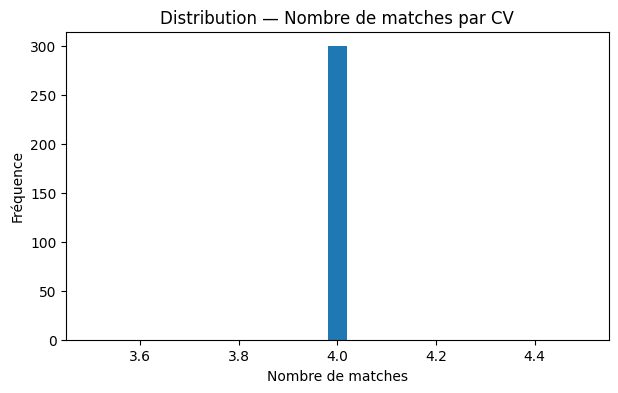

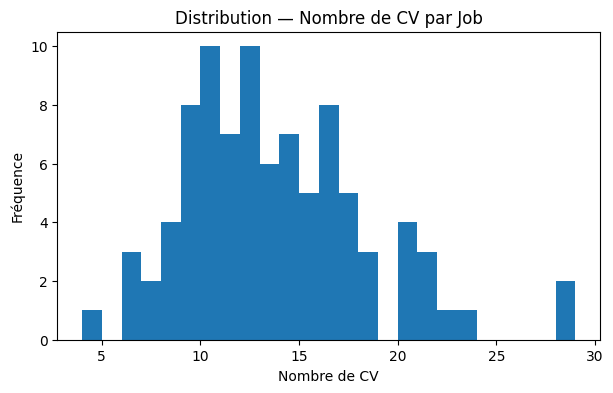

In [13]:
cv_degree = edges_clean["cv_id"].value_counts()
job_degree = edges_clean["job_id"].value_counts()

print("Matches par CV (moyenne):", float(cv_degree.mean()))
print("Matches par Job (moyenne):", float(job_degree.mean()))
print("CV sans match:", (cv_clean["cv_id"].nunique() - cv_degree.index.nunique()))
print("Jobs sans match:", (job_clean["job_id"].nunique() - job_degree.index.nunique()))

plt.figure()
plt.hist(cv_degree.values, bins=25)
plt.title("Distribution — Nombre de matches par CV")
plt.xlabel("Nombre de matches")
plt.ylabel("Fréquence")
plt.show()

plt.figure()
plt.hist(job_degree.values, bins=25)
plt.title("Distribution — Nombre de CV par Job")
plt.xlabel("Nombre de CV")
plt.ylabel("Fréquence")
plt.show()

In [14]:
cv_clean.to_csv(CV_PROC_PATH, index=False)
job_clean.to_csv(JOB_PROC_PATH, index=False)
edges_clean.to_csv(EDGES_PROC_PATH, index=False)

print("✅ Saved processed files:")
print("-", CV_PROC_PATH)
print("-", JOB_PROC_PATH)
print("-", EDGES_PROC_PATH)

✅ Saved processed files:
- data/processed/cv_clean.csv
- data/processed/job_clean.csv
- data/processed/edges.csv


# Conclusion

À ce stade, on a :
- des nœuds CV et Jobs propres (`clean_text`)
- une table d’arêtes cohérente (CV↔Job)
- des statistiques de base sur la structure des correspondances
